# MODELOS

En el siguiente notebook se prueban y se hace el ajuste de hiperparametros de distintos modelos de clasificacion binaria, para la prediccion de la condicion de un producto

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

## Lectura de insumos

en esta seccion se hace la lectura de las variables predictivas y variables objetivo para los set de entrenamiento y pruebas, las variables a utilizar en el modelo son leidas a partir de las transformaciones realizadas en el notebook *02_data_transformation*

In [2]:
# You can safely assume that `build_dataset` is correctly implemented
def build_dataset():
    data = [json.loads(x) for x in open("../data/MLA_100k.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

In [3]:
X_train, y_train, X_test, y_test = build_dataset()
del(X_train,X_test)

Transformaciones finales

In [ ]:
df_X_train_processed = pd.read_csv("X_train_processed.csv")
df_X_test_processed = pd.read_csv("X_test_processed.csv")
y_train_transform = [int(x == "used") for x in y_train]
y_test_transform = [int(x == "used") for x in y_test]

## Desarrollo de modelos 

Se seleccionan tres tipos de modelos para probar, los modelos elegidos son principalmente por su popularidad, e interpretabilidad de resutlados

- Regresion Logistica
- RandomForest
- XGBoost: 
Se emplean dos librerias la primera de *sklearn* y la segunda *xgboost* [link](https://xgboost.readthedocs.io/en/stable/) la cual tiene mejor desempeño que la de sklearn en general

Para cada modelo primero se creara un modelo base, el cual es entrenado con los valores estandar de hiperparametros definidos en las librerias, luego se tratará de mejorar el desempeño del modelo iterando por disitntos valores y configuraciones de hiperparametros.

Para iterar entre los hiperparametros se empleara:
- GridSearch: da un resultado mas robusto ya que no solo itera por los distintos valoresde hiperparametros si no que calcula las metricas de desempeño en distintos *"folds"* de los datos. Estos benedicios se dan en contraposicion a un tiempo mayor de ejecucion.


In [5]:
#pip install xgboost

In [151]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [171]:
dict_accuracy_models = {}
dict_f1_models = {}
dict_precision_models = {}
dict_recall_models = {}

### Regresion Logistica

Se tomara como linea base el resultado de este modelo, para asi poder comparar el resto de modelos y ajuste de hiperparametros

Accuracy: 0.8507


,nombre_col,importancia
34,score_seller,33.212877
33,listing_type_id,16.253335
32,score_popularity_category,15.561720
31,flg_outliers_initial_quantity,5.142932
30,num_variations,4.439768
29,flg_buying_mode_buy_it_now,3.137395
28,accepts_mercadopago,3.003033
27,shipping_local_pick_up,2.662889
26,warranty,2.357809
25,transferencia_bancaria,2.262897


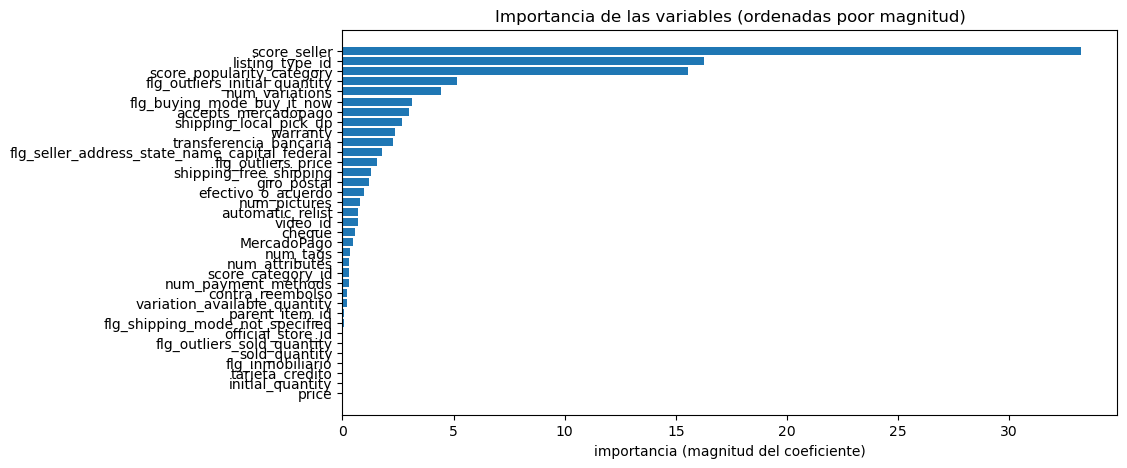

In [232]:
logi = LogisticRegression(max_iter=10000, random_state=42)
logi.fit(df_X_train_processed, y_train_transform)
y_pred = logi.predict(df_X_test_processed)

# Calculate accuracy
accuracy = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["reg_log_base"] = accuracy
print(f'Accuracy: {accuracy:.4f}')
#calculo Precision usado=1
prec = precision_score(y_test_transform, y_pred)
dict_precision_models["reg_log_base"] = prec
#calculo Recall nuevo = 1
rec = recall_score(1-np.array(y_test_transform), 1-y_pred)
dict_recall_models["reg_log_base"] = rec


feature_importance = logi.coef_[0]
absolute_importance = np.abs(feature_importance)
importance_percentage = (absolute_importance / absolute_importance.sum()) * 100

sorted_indices = np.argsort(np.abs(importance_percentage ))[::]
sorted_features = [df_X_train_processed.columns.values[i] for i in sorted_indices]
sorted_importance = importance_percentage[sorted_indices]

display(pd.DataFrame({"nombre_col":sorted_features,"importancia":sorted_importance})\
        .sort_values(by="importancia", ascending=False).head(10))

# Create a bar plot for sorted feature importance
plt.figure(figsize=(10, 5))
plt.barh(sorted_features, sorted_importance)
plt.xlabel('importancia (magnitud del coeficiente)')
plt.title('Importancia de las variables (ordenadas poor magnitud)')
plt.show()

#### Ajuste Hiperparametros

para este modelo se probabran dos tipos de solver `lbfgs` y `liblinear`, los distintos solver tienen interacciones distintas con los parametros segun la documentacion por lo que para evitar tiempos extensos de procesamiento y errores se probabran los valores de `penalty` que son aptos para los dos solver

In [231]:
parameters = {
    'max_iter': [1000,10000],
    'penalty': [None, 'l2'], 
    'solver': ['lbfgs','liblinear']         
}

log_grd = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=parameters,
    verbose=3 
)

log_grd.fit(df_X_train_processed.drop(columns=["score_seller"]),y_train_transform)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END max_iter=1000, penalty=None, solver=lbfgs;, score=0.866 total time=   4.2s
[CV 2/5] END max_iter=1000, penalty=None, solver=lbfgs;, score=0.870 total time=   3.6s


c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END max_iter=1000, penalty=None, solver=lbfgs;, score=0.876 total time=   6.5s
[CV 4/5] END max_iter=1000, penalty=None, solver=lbfgs;, score=0.875 total time=   6.1s
[CV 5/5] END max_iter=1000, penalty=None, solver=lbfgs;, score=0.838 total time=   1.1s
[CV 1/5] END max_iter=1000, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END max_iter=1000, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END max_iter=1000, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END max_iter=1000, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END max_iter=1000, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END max_iter=1000, penalty=l2, solver=lbfgs;, score=0.834 total time=   1.6s
[CV 2/5] END max_iter=1000, penalty=l2, solver=lbfgs;, score=0.871 total time=   2.8s


c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END max_iter=1000, penalty=l2, solver=lbfgs;, score=0.877 total time=   6.7s
[CV 4/5] END max_iter=1000, penalty=l2, solver=lbfgs;, score=0.552 total time=   0.3s
[CV 5/5] END max_iter=1000, penalty=l2, solver=lbfgs;, score=0.838 total time=   0.8s
[CV 1/5] END max_iter=1000, penalty=l2, solver=liblinear;, score=0.855 total time=   1.1s
[CV 2/5] END max_iter=1000, penalty=l2, solver=liblinear;, score=0.801 total time=   0.6s
[CV 3/5] END max_iter=1000, penalty=l2, solver=liblinear;, score=0.551 total time=   0.3s
[CV 4/5] END max_iter=1000, penalty=l2, solver=liblinear;, score=0.854 total time=   0.6s
[CV 5/5] END max_iter=1000, penalty=l2, solver=liblinear;, score=0.767 total time=   0.4s
[CV 1/5] END max_iter=10000, penalty=None, solver=lbfgs;, score=0.866 total time=   3.8s
[CV 2/5] END max_iter=10000, penalty=None, solver=lbfgs;, score=0.870 total time=   3.3s
[CV 3/5] END max_iter=10000, penalty=None, solver=lbfgs;, score=0.881 total time=  32.4s
[CV 4/5] END max_iter=100

c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Paul\anaconda3\envs\tf-gpu2\lib\site-packages\sklearn\linear_model\_logistic.py", line 1172, in fit
    solver = _ch

GridSearchCV(estimator=LogisticRegression(random_state=42),
             param_grid={'max_iter': [1000, 10000], 'penalty': [None, 'l2'],
                         'solver': ['lbfgs', 'liblinear']},
             verbose=3)

- Resultados mejor estimador

In [10]:
print("mejores hiperparametros:")
display(pd.DataFrame([log_grd.best_params_]))

y_pred = log_grd.best_estimator_.predict(df_X_test_processed.drop(columns="score_seller"))
accuracy = accuracy_score(y_test_transform, y_pred)

print(f"accuracy score train: {log_grd.best_score_}")
print(f"accuracy score test: {accuracy}")

mejores hiperparametros:


,max_iter,penalty,solver
0,10000,None,lbfgs


accuracy score train: 0.8664444444444446
accuracy score test: 0.8224


- Calculo metricas mejor modelo

Accuracy: 0.8354


,nombre_col,importancia
34,score_seller,33.220128
33,score_popularity_category,14.887213
32,listing_type_id,12.018433
31,flg_outliers_initial_quantity,6.968570
30,flg_buying_mode_buy_it_now,3.872347
29,accepts_mercadopago,3.807008
28,shipping_local_pick_up,3.284631
27,num_variations,2.517275
26,warranty,2.259467
25,transferencia_bancaria,2.101506


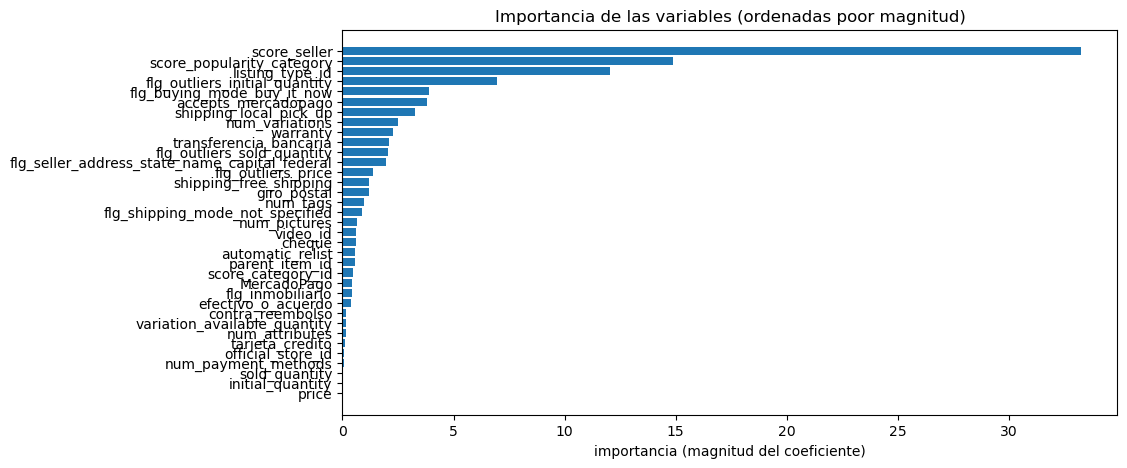

In [230]:
logi_adj = LogisticRegression(random_state=42, max_iter=10000, penalty=None, solver="lbfgs")
logi_adj.fit(df_X_train_processed, y_train_transform)
y_pred = logi_adj.predict(df_X_test_processed)

# Calculate accuracy
accuracy = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["reg_log_ajustado"] = accuracy
print(f'Accuracy: {accuracy:.4f}')
#calculo Precision usado=1
prec = precision_score(y_test_transform, y_pred)
dict_precision_models["reg_log_ajustado"] = prec
#calculo Recall nuevo = 1
rec = recall_score(y_test_transform, y_pred)
dict_recall_models["reg_log_ajustado"] = rec

feature_importance = logi_adj.coef_[0]
absolute_importance = np.abs(feature_importance)
importance_percentage = (absolute_importance / absolute_importance.sum()) * 100

sorted_indices = np.argsort(np.abs(importance_percentage ))[::]
sorted_features = [df_X_train_processed.columns.values[i] for i in sorted_indices]
sorted_importance = importance_percentage[sorted_indices]

display(pd.DataFrame({"nombre_col":sorted_features,"importancia":sorted_importance})\
        .sort_values(by="importancia", ascending=False).head(10))

# Create a bar plot for sorted feature importance
plt.figure(figsize=(10, 5))
plt.barh(sorted_features, sorted_importance)
plt.xlabel('importancia (magnitud del coeficiente)')
plt.title('Importancia de las variables (ordenadas poor magnitud)')
plt.show()

#### Conclusiones
El modelo lineal no logra tomar todas las interacciones de las variables, por lo que se deben probar otros modelos

### XGBoost


#### Modelo Base
para dar una idea del desempeño del modelo, se ejecuta el modelo estandar. 

- En este se evidencia que la variable **score_seller** tiene una importancia mayor al **95%** para la libreria de *sklearn* y superior al **72%** en la libreria *xgboost*, que esta variable tenga tanto peso nos indica que el modelo esta sesgado al valor de esta variable y ya que esta fue creada a partir de la proporcion de productos de la categoria usado que vende un usuario, se puede estar dando un fenomeno de <span style="color: red;"> data leakage </span> por lo que se decide probar nuevamente el modelo sin tener en cuenta esta variable. 

- Cuando se elimina la variable **score_seller** las metricas del modelo mejoran, dando un puntaje de 0.87. Por este motivo de ahora en adelante el ajuste de hiperparametros se realizara en el dataset sin esta variable

- Se determina que la libreria *xgboost* tiene un mejor desempeño que la libreria de *sklearn* por lo que el ajuste de hiperparametros se realizara unicamente con este modelo



- **libreria sklearn**

In [255]:
xg_sk_score = GradientBoostingClassifier()
xg_sk_score.fit(df_X_train_processed, y_train_transform)
y_pred = xg_sk_score.predict(df_X_test_processed)
# Calculo Accuracy
accuracy = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["GB_sklearn_base_con_score"] = accuracy
print("accuracy score: {}".format(accuracy))
#calculo Precision usado=1
prec = precision_score(y_test_transform, y_pred)
dict_precision_models["GB_sklearn_base_con_score"] = prec
#calculo Recall nuevo = 1
rec = recall_score(y_test_transform, y_pred)
dict_recall_models["GB_sklearn_base_con_score"] = rec

feature_importances = xg_sk_score.feature_importances_

importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

accuracy score: 0.8212


,Feature,Importance
29,score_seller,0.958650
1,listing_type_id,0.024443
30,score_popularity_category,0.014779
8,initial_quantity,0.000757
2,price,0.000591
27,num_pictures,0.000234
31,score_category_id,0.000157
3,parent_item_id,0.000135
9,sold_quantity,0.000129
34,flg_outliers_sold_quantity,0.000087


- **libreria xgboost**

In [259]:
xg_xg_score = XGBClassifier()
xg_xg_score.fit(df_X_train_processed, y_train_transform)
y_pred = xg_xg_score.predict(df_X_test_processed)
# Calculo Accuracy
accuracy = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["GB_xgboost_base_con_score"] = accuracy
print("accuracy score: {}".format(accuracy))
#calculo Precision usado=1
prec = precision_score(y_test_transform, y_pred)
dict_precision_models["GB_xgboost_base_con_score"] = prec
#calculo Recall nuevo = 1
rec = recall_score(y_test_transform, y_pred)
dict_recall_models["GB_xgboost_base_con_score"] = rec

feature_importances = xg_xg_score.feature_importances_

importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

accuracy score: 0.8228


,Feature,Importance
29,score_seller,0.715111
1,listing_type_id,0.140954
30,score_popularity_category,0.018049
8,initial_quantity,0.012210
3,parent_item_id,0.012108
9,sold_quantity,0.009065
26,num_tags,0.007317
10,shipping_local_pick_up,0.006933
27,num_pictures,0.006276
2,price,0.006177


- **libreria sklearn sin score_seller**

In [260]:
xg_sk = GradientBoostingClassifier()
xg_sk.fit(df_X_train_processed.drop(columns="score_seller"), y_train_transform)
y_pred = xg_sk.predict(df_X_test_processed.drop(columns="score_seller"))
# Calculo Accuracy
accuracy = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["GB_sklearn_base"] = accuracy
print("accuracy score: {}".format(accuracy))
#calculo Precision usado=1
prec = precision_score(y_test_transform, y_pred)
dict_precision_models["GB_sklearn_base"] = prec
#calculo Recall nuevo = 1
rec = recall_score(y_test_transform, y_pred)
dict_recall_models["GB_sklearn_base"] = rec

feature_importances = xg_sk.feature_importances_

importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.drop(columns="score_seller").columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

accuracy score: 0.8661


,Feature,Importance
29,score_popularity_category,0.652414
1,listing_type_id,0.186656
8,initial_quantity,0.113448
2,price,0.016356
9,sold_quantity,0.005928
27,num_pictures,0.004533
33,flg_outliers_sold_quantity,0.003785
30,score_category_id,0.003108
11,shipping_free_shipping,0.002648
26,num_tags,0.001983


- **libreria XGboost - sin score seller**

In [261]:
xg_xg = XGBClassifier()
xg_xg.fit(df_X_train_processed.drop(columns="score_seller"), y_train_transform)
y_pred = xg_xg.predict(df_X_test_processed.drop(columns="score_seller"))
# Calculo Accuracy
accuracy = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["GB_xgboost_base"] = accuracy
print("accuracy score: {}".format(accuracy))
#calculo Precision usado=1
prec = precision_score(y_test_transform, y_pred)
dict_precision_models["GB_xgboost_base"] = prec
#calculo Recall nuevo = 1
rec = recall_score(y_test_transform, y_pred)
dict_recall_models["GB_xgboost_base"] = rec

feature_importances = xg_xg.feature_importances_

importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.drop(columns="score_seller").columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

accuracy score: 0.8726


,Feature,Importance
1,listing_type_id,0.266877
29,score_popularity_category,0.249715
8,initial_quantity,0.131371
11,shipping_free_shipping,0.055492
9,sold_quantity,0.028005
0,warranty,0.021728
17,MercadoPago,0.021687
26,num_tags,0.018054
22,tarjeta_credito,0.015801
27,num_pictures,0.015323


#### Ajuste Hiperparametros

resultado de analizar el modelo base el ajuste de hiperparametros solo se realizara sobre:
- modelo de la libreria xgboost
- modelo sin la variable score_seller

##### Grid Search

In [16]:
learning_rate = np.arange(0.41,0.71,0.1)
max_depth = np.arange(2,8,2)
n_estimators = np.arange(94,106,2)
lambda_values = np.arange(0,2,1)
alpha_values = np.arange(0,2,1)

parameters = {"n_estimators":n_estimators, 
              "max_depth":max_depth,
              "learning_rate":learning_rate,
              "reg_lambda": lambda_values,
              "reg_alpha":alpha_values
              }

xgb_grd = GridSearchCV(XGBClassifier(), parameters, verbose = 3)
xgb_grd.fit(df_X_train_processed.drop(columns=["score_seller"]),y_train_transform)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 1/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_lambda=0;, score=0.904 total time=   0.1s
[CV 2/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_lambda=0;, score=0.905 total time=   0.1s
[CV 3/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_lambda=0;, score=0.903 total time=   0.1s
[CV 4/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_lambda=0;, score=0.908 total time=   0.1s
[CV 5/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_lambda=0;, score=0.905 total time=   0.1s
[CV 1/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_lambda=1;, score=0.904 total time=   0.1s
[CV 2/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_lambda=1;, score=0.906 total time=   0.1s
[CV 3/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_la

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': array([0.41, 0.51, 0.61]),
                         'max_depth': array([2, 4, 6]),
                         'n_estimators': array([ 94,  96,  98, 100, 102, 104]),
                         'reg_alpha': array([0, 1]),
                         'reg_lambda': array([0, 1])},
             verbose=3)

En la siguiente ceda se obtiene el mejor modelo despues de la busqueda por gridsearch, y ademas se muestran los resultados de la metrica de desempeño evaluada, que en este caso es accuracy.

Se ve que para el set de entrenamiento el accuracy es **0.91** mientras que para el set de pruebas es de **0,86** esta diferencia indica que puede existir un sobreajuste del modelo a pesar de haber realizado un entrenamiento con *folds*. Sin embargo a pesar de esto el modelo tiene un buen desempeño

In [17]:
print("mejores hiperparametros:")
display(pd.DataFrame([xgb_grd.best_params_]))

y_pred = xgb_grd.best_estimator_.predict(df_X_test_processed.drop(columns="score_seller"))
accuracy = accuracy_score(y_test_transform, y_pred)

print(f"accuracy score train: {xgb_grd.best_score_}")
print(f"accuracy score test: {accuracy}")

mejores hiperparametros:


,learning_rate,max_depth,n_estimators,reg_alpha,reg_lambda
0,0.41,6,100,0,1


accuracy score train: 0.9124222222222222
accuracy score test: 0.8745


- Metricas mejor estimador

In [262]:
xg = XGBClassifier(learning_rate=0.41, max_depth=6,n_estimators=100,reg_lambda = 0, reg_alpha= 1)
xg.fit(df_X_train_processed.drop(columns=["score_seller"]), y_train_transform)
y_pred = xg.predict(df_X_test_processed.drop(columns=["score_seller"]))

roc = roc_auc_score(y_test_transform, y_pred, average='macro')
# Calculo Accuracy
accuracy = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["GB_xgboost_ajustado"] = accuracy
#calculo Precision usado=1
prec = precision_score(y_test_transform, y_pred)
dict_precision_models["GB_xgboost_ajustado"] = prec
#calculo Recall nuevo = 1
rec = recall_score(y_test_transform, y_pred)
dict_recall_models["GB_xgboost_ajustado"] = rec

print(f"area bajo la curva roc: {roc}")
print(f"accuracy score test: {accuracy}")

area bajo la curva roc: 0.8741428081570147
accuracy score test: 0.8752


In [263]:
feature_importances = xg.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.drop(columns=["score_seller"]).columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
importance_df.reset_index(drop=True, inplace=True)
importance_df.head(10)

,Feature,Importance
0,listing_type_id,0.268401
1,score_popularity_category,0.227362
2,initial_quantity,0.131090
3,shipping_free_shipping,0.046798
4,sold_quantity,0.029839
5,MercadoPago,0.029503
6,accepts_mercadopago,0.029035
7,warranty,0.017074
8,num_tags,0.016955
9,giro_postal,0.015888


### Random Forest

#### Modelo Base
para dar una idea del desempeño del modelo, se ejecuta el modelo estandar. 

- En este se evidencia que la variable **score_seller** tiene una importancia mayor al **50%** inspirado en el modelo aterior, se decide eliminar esta variable del analisis para asi poder encontrar relaciones que generalicen mejor el problema

- Cuando se elimina la variable **score_seller** las metricas del modelo mejoran, dando un puntaje de **87%**

- **con score seller**

In [264]:
rf_score = RandomForestClassifier(random_state=123)
rf_score.fit(df_X_train_processed, y_train_transform)
y_pred = rf_score.predict(df_X_test_processed)
# Calculo Accuracy
accuracy = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["RF_base_con_score"] = accuracy
print("accuracy score: {}".format(accuracy))
#calculo Precision usado=1
prec = precision_score(y_test_transform, y_pred)
dict_precision_models["RF_base_con_score"] = prec
#calculo Recall nuevo = 1
rec = recall_score(y_test_transform, y_pred)
dict_recall_models["RF_base_con_score"] = rec

feature_importances = rf_score.feature_importances_

importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

accuracy score: 0.8217


,Feature,Importance
29,score_seller,0.528679
30,score_popularity_category,0.159883
1,listing_type_id,0.073792
8,initial_quantity,0.071108
2,price,0.036776
33,flg_outliers_initial_quantity,0.030903
31,score_category_id,0.019485
34,flg_outliers_sold_quantity,0.015085
9,sold_quantity,0.009435
27,num_pictures,0.008971


- **sin score seller**

In [265]:
rf = RandomForestClassifier(random_state=123)
rf.fit(df_X_train_processed.drop(columns="score_seller"), y_train_transform)
y_pred = rf.predict(df_X_test_processed.drop(columns="score_seller"))
# Calculo Accuracy
accuracy = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["RF_base"] = accuracy
print("accuracy score: {}".format(accuracy))
#calculo Precision usado=1
prec = precision_score(y_test_transform, y_pred)
dict_precision_models["RF_base"] = prec
#calculo Recall nuevo = 1
rec = recall_score(y_test_transform, y_pred)
dict_recall_models["RF_base"] = rec

feature_importances = rf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.drop(columns="score_seller").columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

accuracy score: 0.8722


,Feature,Importance
29,score_popularity_category,0.349948
1,listing_type_id,0.120784
2,price,0.100615
8,initial_quantity,0.090810
30,score_category_id,0.065166
32,flg_outliers_initial_quantity,0.064194
27,num_pictures,0.034479
33,flg_outliers_sold_quantity,0.024736
9,sold_quantity,0.023318
28,num_payment_methods,0.014033


#### Ajuste Hiperparametros

##### Grid Search

In [22]:
n_criterion = ["gini", "entropy", "log_loss"]
n_max_depth = np.arange(5,35, 5)
n_max_features = np.arange(1,6,1)
n_estimators = np.arange(100,130,10)

parameters = {"criterion": n_criterion, 
              "max_depth":n_max_depth,               
              "max_features":n_max_features,
              "n_estimators":n_estimators
              }
rf_grd = GridSearchCV(RandomForestClassifier(random_state=123, n_jobs=-1), parameters, verbose = 3)
rf_grd.fit(df_X_train_processed.drop(columns="score_seller"),y_train_transform)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV 1/5] END criterion=gini, max_depth=5, max_features=1, n_estimators=100;, score=0.876 total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=5, max_features=1, n_estimators=100;, score=0.873 total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=5, max_features=1, n_estimators=100;, score=0.871 total time=   0.3s
[CV 4/5] END criterion=gini, max_depth=5, max_features=1, n_estimators=100;, score=0.877 total time=   0.3s
[CV 5/5] END criterion=gini, max_depth=5, max_features=1, n_estimators=100;, score=0.876 total time=   0.3s
[CV 1/5] END criterion=gini, max_depth=5, max_features=1, n_estimators=110;, score=0.874 total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=5, max_features=1, n_estimators=110;, score=0.869 total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=5, max_features=1, n_estimators=110;, score=0.870 total time=   0.3s
[CV 4/5] END criterion=gini, max_depth=5, max_features=1, n_estimators=1

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=123),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([ 5, 10, 15, 20, 25, 30]),
                         'max_features': array([1, 2, 3, 4, 5]),
                         'n_estimators': array([100, 110, 120])},
             verbose=3)

- Mejor estimador

In [23]:
print("mejores hiperparametros:")
display(pd.DataFrame([rf_grd.best_params_]))

y_pred = rf_grd.best_estimator_.predict(df_X_test_processed.drop(columns="score_seller"))
accuracy = accuracy_score(y_test_transform, y_pred)

print(f"accuracy score train: {rf_grd.best_score_}")
print(f"accuracy score test: {accuracy}")

mejores hiperparametros:


,criterion,max_depth,max_features,n_estimators
0,gini,30,5,110


accuracy score train: 0.9131333333333334
accuracy score test: 0.8758


- Medidas mejor estimador

In [266]:
rf_adj = RandomForestClassifier(random_state=123, n_jobs=-1, criterion= "gini", max_depth=23, max_features=4, n_estimators=110)

rf_adj.fit(df_X_train_processed.drop(columns=["score_seller"]), y_train_transform)
y_pred = rf_adj.predict(df_X_test_processed.drop(columns=["score_seller"]))

roc = roc_auc_score(y_test_transform, y_pred, average='macro')
# Calculo Accuracy
accuracy = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["RF_ajustado"] = accuracy
#calculo Precision usado=1
prec = precision_score(y_test_transform, y_pred)
dict_precision_models["RF_ajustado"] = prec
#calculo Recall nuevo = 1
rec = recall_score(y_test_transform, y_pred)
dict_recall_models["RF_ajustado"] = rec

print(f"area bajo la curva roc: {roc}")
print(f"accuracy score test: {accuracy}")

area bajo la curva roc: 0.8752316272201786
accuracy score test: 0.8759


In [ ]:
feature_importances = rf_adj.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.drop(columns=["score_seller"]).columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
importance_df.reset_index(drop=True, inplace=True)
importance_df.head(10)

,Feature,Importance
0,score_popularity_category,0.337673
1,listing_type_id,0.138643
2,initial_quantity,0.102826
3,price,0.081007
4,flg_outliers_initial_quantity,0.063893


### Modelos combinados tipo: voting classifier
Con la idea de utilizar los dos modelos que mejor desempeño tuvieron se utilizan estrategias que permiten utilizar los resultados de los dos modelos para calcular un nuevo resultado.

Para este clasificador se emplearan las versiones ajustadas anteirormente de cada modelo.




- **VotingClassifier:** Esta toma las predicciones realizadas por cada modelo las sopesa (proceso de votacion) y entrega un nuevo resultado a partir de estas. 

In [182]:
estimators = [
    ("xg", XGBClassifier(learning_rate=0.41, max_depth=6,n_estimators=104,reg_lambda = 1, reg_alpha= 1)),
    ("rf", RandomForestClassifier(random_state=123, n_jobs=-1, criterion= "gini", max_depth=23, max_features=4, n_estimators=110))
]

vote = VotingClassifier(estimators=estimators, voting="soft", n_jobs=-1)
vote.fit(df_X_train_processed.drop(columns=["score_seller"]), y_train_transform)

y_pred = vote.predict(df_X_test_processed.drop(columns=["score_seller"]))

roc_vote = roc_auc_score(y_test_transform, y_pred, average='macro')
# Calculo Accuracy
accuracy_vote = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["voting_classifier"] = accuracy_vote

#calculo Precision usado=1
prec = precision_score(y_test_transform, y_pred)
dict_precision_models["voting_classifier"] = prec
#calculo Recall nuevo = 1
rec = recall_score(y_test_transform, y_pred)
dict_recall_models["voting_classifier"] = rec

print(f"vote: area bajo la curva roc: {roc_vote}")
print(f"vote: accuracy score test: {accuracy_vote}")

vote: area bajo la curva roc: 0.8745837555169759
vote: accuracy score test: 0.8755


- **StackingClassifier:** esta metodologia en lugar de utilizar una votacion para decidir utiliza la salida de los modelos como entraads de un modelo final, que en este caso sera una regresion logistica.

In [183]:
estimators = [
    ("xg", XGBClassifier(learning_rate=0.41, max_depth=6,n_estimators=104,reg_lambda = 1, reg_alpha= 1)),
    ("rf", RandomForestClassifier(random_state=123, n_jobs=-1, criterion= "gini", max_depth=23, max_features=4, n_estimators=110))
]

stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=123, n_jobs=-1))
stack.fit(df_X_train_processed.drop(columns=["score_seller"]), y_train_transform)

y_pred = stack.predict(df_X_test_processed.drop(columns=["score_seller"]))

roc_stack = roc_auc_score(y_test_transform, y_pred, average='macro')
# Calculo Accuracy
accuracy_stack = accuracy_score(y_test_transform, y_pred)
dict_accuracy_models["stack_classifier"] = accuracy_stack

#calculo Precision usado=1
prec = precision_score(y_test_transform, y_pred)
dict_precision_models["stack_classifier"] = prec
#calculo Recall nuevo = 1
rec = recall_score(y_test_transform, y_pred)
dict_recall_models["stack_classifier"] = rec

print(f"stack: area bajo la curva roc: {roc_stack}")
print(f"stack: accuracy score test: {accuracy_stack}")

stack: area bajo la curva roc: 0.875143405535796
stack: accuracy score test: 0.8766


## Comparacion de modelos

Esta comparacion de modelos se realiza exclusivamente teniendo en cuenta la variabl **accuracy**

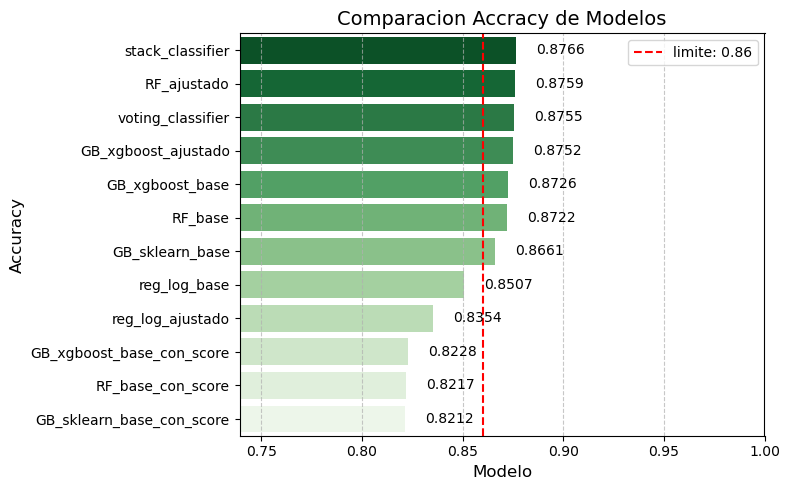

In [184]:
# Transform the dictionary into a DataFrame
df_accuracy = pd.DataFrame(list(dict_accuracy_models.items()), columns=['Modelo', 'Accuracy'])

# Sort the DataFrame by Accuracy (descending order)
df_accuracy = df_accuracy.sort_values(by='Accuracy', ascending=False)

# Plot a vertical barplot with a green gradient
plt.figure(figsize=(8, 5))
ax = sns.barplot(y='Modelo', x='Accuracy', data=df_accuracy, palette="Greens_r")

for i, value in enumerate(df_accuracy['Accuracy']):
    ax.text(value + 0.01, i, f"{value:.4f}", va='center', fontsize=10)


# Add labels and title
plt.title('Comparacion Accracy de Modelos', fontsize=14)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xlim(min(df_accuracy["Accuracy"]*0.9), 1)  # Ensure the y-axis reflects accuracy as a percentage (0 to 1)
plt.axvline(0.86, 0,1, color="red", ls="--", label="limite: 0.86")
# Rotate x-axis labels for better visibility
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

# Metrica Propuesta
- Dado que el problema es balanceado la medida de *Accuracy* no tiene problemas evidentes como cuando la clase objetivo es desbalanceada

- La eleccion de una metrica u otra depende de la distribucion de las clases a clasificar y la aplicacion final del modelo realizado, el costo asociado a realizar una prediccion incorrecta. Algunas aplicaciones pueden ser:

    - Mejorar la experiencia de usuario identificando los productos nuevos o usados que no han sido marcados para una mejora en los modelos de recomendacion o filtrado.

    - Cumplimiento de politicas, prevencion de fraude. puede que los productos que no estan correctamente identificados como usados, sean de alto riesgo ya que el vendedor no esta indicando claramente las caracteristicas del producto. Todo esto finalmente se traduce en la confianza que genera mercado libre en sus compradores

- Segun la documentacion de mercado libre ([ref cargos venta](https://www.mercadolibre.com.co/ayuda/Costos-de-vender-productos_870)) un cliente puede ser eximido de pagar estos cargos hasta en 20 ventas por año, solo si su producto es del tipo usado. Asumamos como caso de fraude la clasificación intencional de un producto como usado por parte de usuarios de Mercado Libre. En este escenario, Mercado Libre perdería la comisión correspondiente. A causa de esto<span style="color: darkgreen;"> el objetivo del problema es en minimizar la perdida de comision por parte de la clasificacion errada de productos nuevos como usados </span>

- dependiendo de cual variable objetivo se seleccione para predecir, se tendra que un tipo de error es mas costoso que otro.

    <center>
    
    | Actual \ Predicted | Positive             | Negative             |
    |--------------------|----------------------|----------------------|
    | Positive           | True Positive (TP)   | False Negative (FN)  |
    | Negative           | False Positive (FP)  | True Negative (TN)   |
    
    </center>
    
    si la variable a predecir es: 1 = usado, la comision se perdera cuando se clasifique erroneamente a un **Falso positivo**, en cuyo caso la variable que minimiza esto es la **precision**

    si la variable a predecir es: 1 = nuevo, la comision se perdera cuando se clasifique erroneamente a un **Falso Negativo**, en cuyo caso la variable que minimiza esto es **recall**

- tambien se plantea una metrica que responde a una dinamica de negocio, en este caso la perdida del cargo por venta, que esta entre el 9% y 20% (dependiendo del producto y el tpo del publicacion), para este ejercicio se utilizara como cargo por venta el promedio entre estos limites 14.5%.
    
    el calculo de la perdida sera:
    $$
        \text{perdida} = \text{flag falso positivo}*\text{precio articulo}*14.5
    $$

- Medida de precision

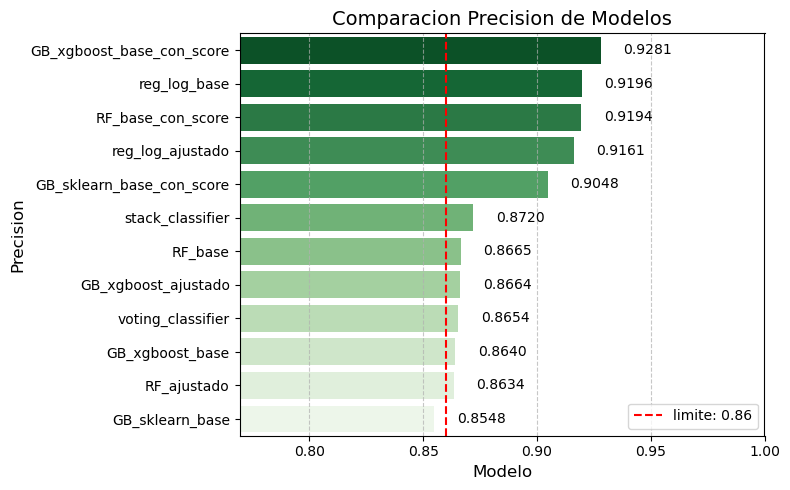

In [187]:
# Transform the dictionary into a DataFrame
df_f1 = pd.DataFrame(list(dict_precision_models.items()), columns=['Modelo', 'Precision'])

# Sort the DataFrame by Accuracy (descending order)
df_f1 = df_f1.sort_values(by='Precision', ascending=False)

# Plot a vertical barplot with a green gradient
plt.figure(figsize=(8, 5))
ax = sns.barplot(y='Modelo', x='Precision', data=df_f1, palette="Greens_r")

for i, value in enumerate(df_f1['Precision']):
    ax.text(value + 0.01, i, f"{value:.4f}", va='center', fontsize=10)


# Add labels and title
plt.title('Comparacion Precision de Modelos', fontsize=14)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.xlim(min(df_f1["Precision"]*0.9), 1)  # Ensure the y-axis reflects accuracy as a percentage (0 to 1)
plt.axvline(0.86, 0,1, color="red", ls="--", label="limite: 0.86")
# Rotate x-axis labels for better visibility
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

- Medida de Recall
es importante resaltar que los modelos anteriores fueron creados para qe usado = 1, para transformarlo en un predictor de 1 = nuevo se realiza:

    $\text{pred nuevo} = 1 - \text{pred usado}$

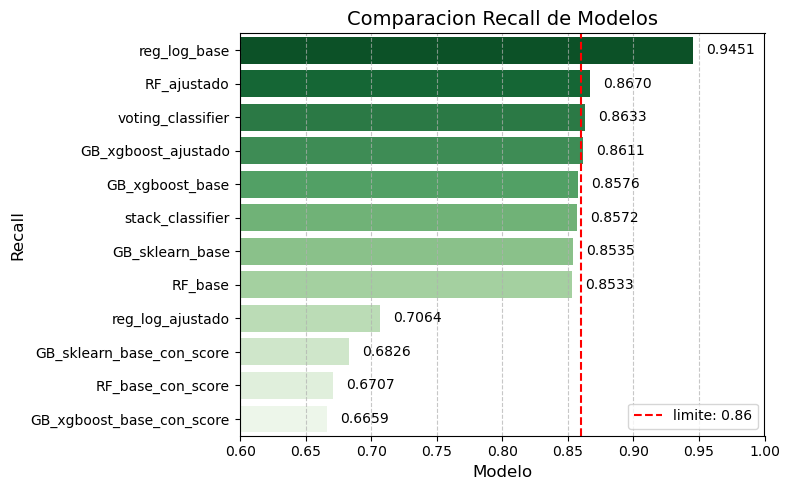

In [ ]:
# Transform the dictionary into a DataFrame
df_f1 = pd.DataFrame(list(dict_recall_models.items()), columns=['Modelo', 'Recall'])

# Sort the DataFrame by Accuracy (descending order)
df_f1 = df_f1.sort_values(by='Recall', ascending=False)

# Plot a vertical barplot with a green gradient
plt.figure(figsize=(8, 5))
ax = sns.barplot(y='Modelo', x='Recall', data=df_f1, palette="Greens_r")

for i, value in enumerate(df_f1['Recall']):
    ax.text(value + 0.01, i, f"{value:.4f}", va='center', fontsize=10)


# Add labels and title
plt.title('Comparacion Recall de Modelos', fontsize=14)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.xlim(min(df_f1["Recall"]*0.9), 1)  # Ensure the y-axis reflects accuracy as a percentage (0 to 1)
plt.axvline(0.86, 0,1, color="red", ls="--", label="limite: 0.86")
# Rotate x-axis labels for better visibility
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

- Medida de perdida cargo venta

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


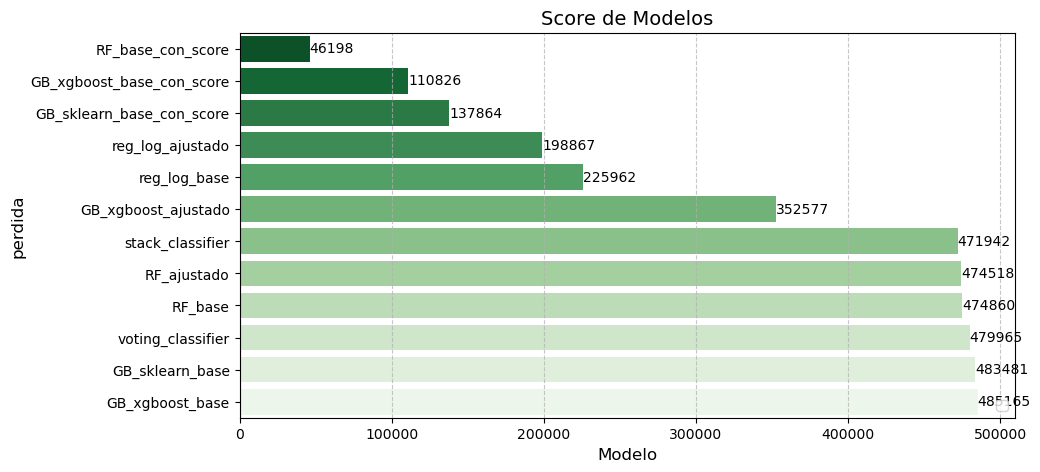

In [280]:
dict_result = {}
models = {"reg_log_base":logi,
"reg_log_ajustado":logi_adj,
"GB_sklearn_base_con_score":xg_sk_score,
"GB_xgboost_base_con_score":xg_xg_score,
"GB_sklearn_base":xg_sk,
"GB_xgboost_base":xg_xg,
"GB_xgboost_ajustado":xg,
"RF_base_con_score":rf_score,
"RF_base":rf,
"RF_ajustado":rf_adj,
"voting_classifier":vote,
"stack_classifier":stack
}

def calculo_perdida_por_fraude(nombre,model):
    if "reg_log" in nombre or "score" in nombre:
        y_pred = model.predict(df_X_test_processed)
    else:
        y_pred = model.predict(df_X_test_processed.drop(columns=["score_seller"]))
    
    falsos_positivos = np.array(y_pred) > np.array(y_test_transform)
    perdida = (df_X_test_processed.loc[falsos_positivos,"price"]*0.16).sum()
    return perdida


for k,v in models.items():
    dict_result[k] = calculo_perdida_por_fraude(k,v)


df = pd.DataFrame(dict_result.items(),
                  columns=["modelo","perdida"]).sort_values(by="perdida")

# Plot a vertical barplot with a green gradient
plt.figure(figsize=(10, 5))
ax = sns.barplot(y='modelo', x='perdida', data=df, palette="Greens_r")

for i, value in enumerate(df['perdida']):
    ax.text(value + 0.05, i, f"{value:.0f}", va='center', fontsize=10)

# Add labels and title
plt.title('Score de Modelos', fontsize=14)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('perdida', fontsize=12)
# plt.axvline(0.86, 0,1, color="red", ls="--", label="limite: 0.86")
# Rotate x-axis labels for better visibility
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()

#### Mejor Modelo

Para determinar el mejor modelo en general se crea un score en el cual se suman el ranking en el que se ubica cada modelo para cada metrica, siendo un score menor mejor que un score mayor.

$$
\text{Score} = \text{Accuracy ranking} + \text{Precission ranking} + \text{Recall ranking} + \text{Cargo venta ranking}
$$

- en la siguiente grafica se observa que el mejor modelo es el de regresion logistica base, sin embargo este hace uso de la variable `score_seller` que identificamos tiene desventajas para el objetivo planteado por lo que el segundo mejor modelo <span style="color: darkgreen;">**stack_calssifier**</span> sera elegido.

,Key,Rank_acc,Rank_prec,Rank_rec,Rank_cstm,Score
10,voting_classifier,3.0,9.0,3.0,3.0,18.0
0,reg_log_base,8.0,2.0,1.0,8.0,19.0
11,stack_classifier,1.0,6.0,6.0,6.0,19.0
9,RF_ajustado,2.0,11.0,2.0,5.0,20.0
5,GB_xgboost_base,5.0,10.0,5.0,1.0,21.0
6,GB_xgboost_ajustado,4.0,8.0,4.0,7.0,23.0
8,RF_base,6.0,7.0,8.0,4.0,25.0
4,GB_sklearn_base,7.0,12.0,7.0,2.0,28.0
1,reg_log_ajustado,9.0,4.0,9.0,9.0,31.0
3,GB_xgboost_base_con_score,10.0,1.0,12.0,11.0,34.0


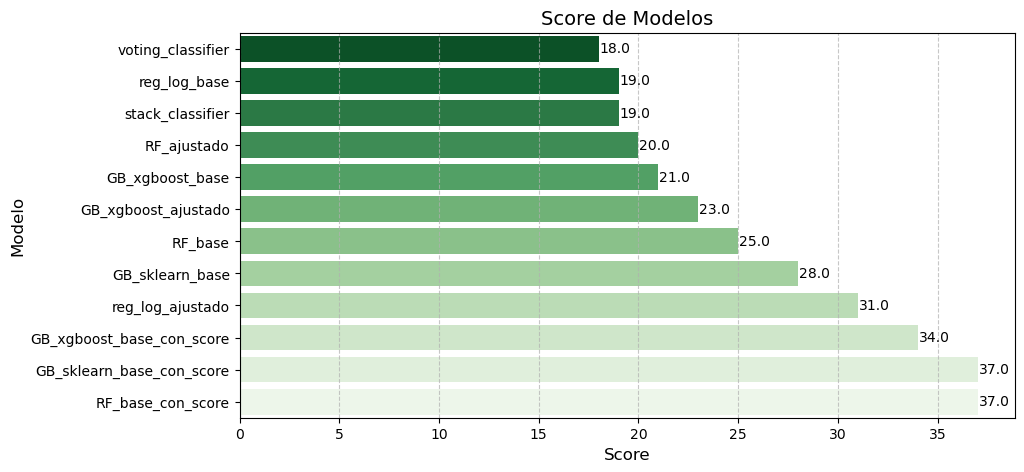

In [290]:
df = pd.DataFrame({
    'accuracy': dict_accuracy_models,
    'precision': dict_precision_models,
    'recall': dict_recall_models,
    "custom": dict_result
}).reset_index()

# Rename columns for clarity
df.rename(columns={'index': 'Key'}, inplace=True)

# Calculate rank for each column (higher value gets a higher rank)
df['Rank_acc'] = df['accuracy'].rank(ascending=False)
df['Rank_prec'] = df['precision'].rank(ascending=False)
df['Rank_rec'] = df['recall'].rank(ascending=False)
df['Rank_cstm'] = df['custom'].rank(ascending=False)

# Sum the ranks into a new column
df['Score'] = df['Rank_acc'] + df['Rank_prec'] + df['Rank_rec'] + df['Rank_cstm']
df = df.sort_values(by="Score")

display(df[["Key","Rank_acc","Rank_prec","Rank_rec","Rank_cstm","Score"]])

# Plot a vertical barplot with a green gradient
plt.figure(figsize=(10, 5))
ax = sns.barplot(y='Key', x='Score', data=df, palette="Greens_r")

for i, value in enumerate(df['Score']):
    ax.text(value + 0.05, i, f"{value}", va='center', fontsize=10)

# Add labels and title
plt.title('Score de Modelos', fontsize=14)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Modelo', fontsize=12)
# plt.axvline(0.86, 0,1, color="red", ls="--", label="limite: 0.86")
# Rotate x-axis labels for better visibility
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
#plt.legend(loc="lower right")
plt.show()

- Si nos guiamos exclusivamente por las metricas el mejor modelo es **voting_classifier** sin embargo, el modelo no es directamente interpretable si por algun motivo de negocio el modelo necesita ser altamente interpretable la mejor seleccion sera el modelo de **random forest ajustado**, sin embargo a continuacion se muestra una aproximacion para el calculo de la importancia de las variables para el voting_classifier

In [311]:
from sklearn.inspection import permutation_importance

r = permutation_importance(vote, df_X_train_processed.drop(columns="score_seller"), y_train_transform,
                           n_repeats=30,
                           random_state=0)

feature_names = df_X_train_processed.drop(columns="score_seller").columns
importances = r.importances_mean
std = r.importances_std

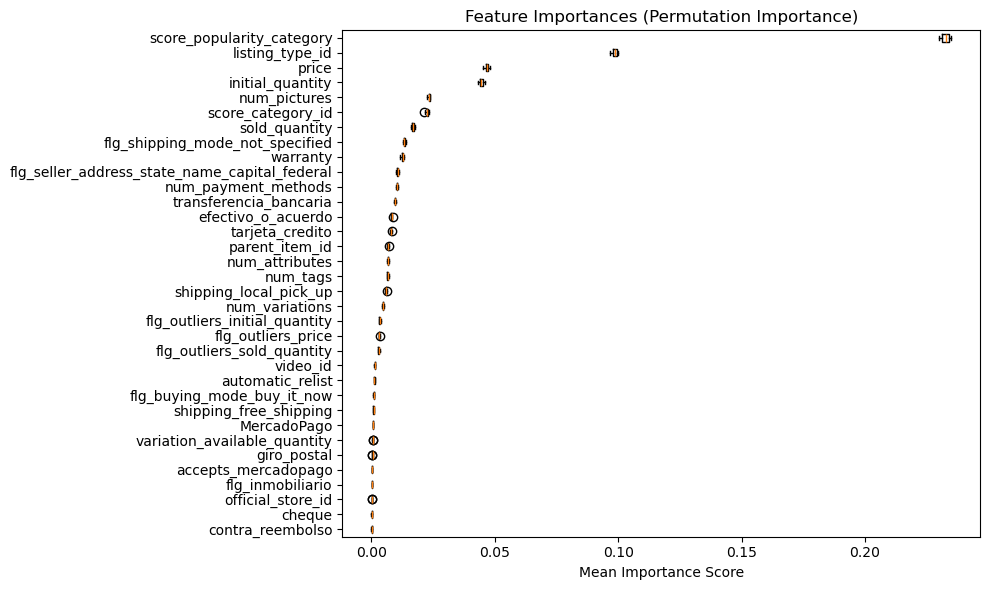

In [312]:
# Sorting feature importances in descending order
sorted_idx = np.argsort(importances)[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importances = importances[sorted_idx]
sorted_std = std[sorted_idx]

# Plotting the feature importances
plt.figure(figsize=(10, 6))
#plt.barh(sorted_features, sorted_importances, xerr=sorted_std, align='center', color="green")
plt.boxplot(r.importances[sorted_idx].T, vert=False, labels=sorted_features)
plt.gca().invert_yaxis()  # Reverse the order to show the highest importance at the top
plt.xlabel('Mean Importance Score')
plt.title('Feature Importances (Permutation Importance)')
plt.tight_layout()
plt.show()

## Conclusiones Modelos

- Incluso en la etapa de calibracion y etnrenamiento puede ayudar a eliminar nuevas variables del analisis final, en este caso la variablre `score_seller`, la cual tenia una importancia muy alta en todos los modelos, por lo que se decidio eliminarla, ya que al ser calculada como un score que tiene en cuenta la variable objetivo se puede estar incurriendo en un *dataleakage*

- Se pueden tener varias metricas en cuenta y sopesar varios resultados atraves de la creacion de un score para los modelos, ya que puede que no solo una metrica sea la mejor.

- El mejor modelo de esta iteracion es el de la estrategia <span style="color: darkgreen;">**Voting Calssifier**</span> ya que tiene un buen desempeño en todas las metricas evaluadas, bajo el criterio del score planteado

- para las metrica perdida de cargo por venta se ven que las primeras posiciones las componen los modelos que tienen en cuenta la variable `score_seller`, sin embargo como identificamos antes, esta variable tiene una desventaja frente al problema planteado ya que los vendedores de productos usados son vendedores ocacionales, y en caso de fraude mucho de los vendedores serán nuevos usuarios haciendo que esta variable pierda poder predictivo. por lo tanto se tendran en cuenta los modelos que no cuentan con esta variable para tomar una decision.

- a través de la importancia de las variables se puede interpretar: 
    - cierta predisposicion de venta de usados en ciertas categorias de producto 
    - el tipo de listado elegido por el vendedor da una pista de que tipo de producto se vende siendo categorias mas bajas asociadas a productos usados y categorias mas altas asociadas a nuevos
    - la cantidad de productos es tambien un indicador, esto por que en general la venta de un usado es una venta ocacional y no es comun tener "stock" de dicho producto
    - El precio del producto es un indicador de nuevo o usado, usualmnte el valor del usado sera menor a un producto nuevo de la misma categoria, ejemplo televisores, camaras, ropa . etc...
    - 


### siguientes pasos
#### Modelo
- El modelo podria mejorarse analizando las variables:
    - Titulo: aplicando NLP para determinar si hay texto asociado a un tipo de producto.
    - lat, longitud: es probable que geograficamente zonas residenciales o ciertos barrios sean más propensos a tener ventasde usados. mientras que zonas comerciales puedan ser mas propensos a venta de usados
    - obtener mas informacion de la categoria de los productos por medio de la API de mercado libre

#### Negocio
- Con el modelo identifiado se puede monitorear aquellos productos que el modelo marca como usados y que en su publicacion estan listados como nuevos, esto para ver si es un caso de fraude o no, adicional a la informacion del modelo se puede priorizar la revision de los articulos, enriqueciendo con la calificacion del cliente, fecha de vinculacion priorizando los nuevos y el valor de bien.


- En el analisis exploratorio se identificaron oportunidades de negocio que pueden ser profunizadas.

    - existe una mayor proporcion de vendedores de productos usados que aceptan mercadopago, esto se debe a que puede ser una opcion rápida para obtener el dinero solicitado, esta preferencia puede ser una oportunidad para mercadopago, sin embargo hay que tener especial atencion para mitigar con los casos de fraude y/o devoluciones de producto.

    - cuado el producto tiene asociado *free shipping* es mas probable que sea nuevo, esto puede deberse nuevamente a que el vendedor de un producto usado es un vendedor ocacional y no tiene una vinculacion con un transportista o mercado libre para el envio de productos y posiblemente este buscando conciliar con el comprador los costos de envio. Aca puede existir una oportunidad para que mercado libre analice el por que los vendedores de usados no estan utilizando esto. Quizas mejorando las condiciones de free shipping para los vendedores ocacionales, con centros de recoleccion de productos, los vendedores pueden ofrecer envio gratuito y hacer mas atractivo el producto. ([ref free shipping](https://www.mercadolibre.com.co/ayuda/Costos-de-envios-gratis_3703))

    - si el cliente acepta transferencia bancaria es mas probable que el cliente venda un producto nuevo, la baja aceptacion por parte de los vendedores de usado por las transferencias bancarias puede ser por que no estan vinculados al sistema financiero o tienen baja confianza en el mismo, esta puede ser una oportunidad para mercadopago para profundizar estos clientes

    - para los elementos que describen la cantidad de variaciones, atributos o tags que tiene la publicacion del producto se ve una tendencia a que los productos nuevos tengan una mayor cantidad de estos, posiblemente por que el vendedor del producto nuevo es mas especializado y pone mas cuidado a la creacion de su publicacion, si luego de un analisis se determina que los productos nuevos con mas de estas propiedades tienen mas ventas o vistas, hay una oportunidad para mercado libre para que los vendedores de usados llenen estos campos o por medio de algun modelo automaticamente llenar estos campos para mejorar sus vistas y ventas.